<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/00-01-exploracion_correos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo 50 JAIIO: TF-IDF
__Título:__ Etiquetado semi-supervisado multiclase de correos electrónicos a partir de estrategias de extracción de características y _Elasticsearch_

__Autores:__ Juan Manuel Fernandez, Marcelo Errecalde


En esta notebook se presentan gráficos de distribución de frecuencias por clase para los dataset de train, test e integrado para las 50 JAIIO.

## 0. Misceláneos:

### Descarga de librerias necesarias

In [1]:
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=851878f23483e9465cf22f9440c07385a3a09294ef6bf3bea2171d53524de9f9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import consolidar_df, get_clases

### Descarga dataset de training ya discretizado y con 800 correos etiquetados:

In [3]:
# Descargo los correos ya etiquetados
from os import path

if not (path.exists('correos-train-80.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv

if not (path.exists('correos-test-20.csv')):
    !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv

--2021-06-12 10:58:16--  https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-train-80.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223169 (218K) [text/plain]
Saving to: ‘correos-train-80.csv’

correos-train-80.cs 100%[===================>] 217.94K  --.-KB/s    in 0.01s   

2021-06-12 10:58:16 (16.9 MB/s) - ‘correos-train-80.csv’ saved [223169/223169]

--2021-06-12 10:58:17--  https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/correos-test-20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

## 1. Presentación del dataset:

### 1.1 Se levanta en un DataFrame para poder manipularlo

In [4]:
import pandas as pd

# Cargo correos en un dataframe
correos_train = pd.read_csv('correos-train-80.csv')
correos_test = pd.read_csv('correos-test-20.csv')

### 1.2 Muestro 5 consultas

In [5]:
# Muestro por completo las primeras 5 consultas
for idx, e in enumerate(correos_train['Consulta'][0:5]):
    print(f'{idx+1} - {e}\n')

1 - quisiera saber porque no tengo el numero de legajo? lo necesitaria para poder anotarme en los horarios de las materias. muchas gracias 

2 - quería cambiarme al prof. de educ. física. quiero ver la oferta de asignaturas y así ver los horarios, ya que me dijeron qué tenía abril/mayo para el cambio de carrera. pero no me deja entrar porque dice que el período de inscripción no está vigente. gracias 

3 - hola. quiero saber en que condición estoy para retomar la carrera. ya estuve libre y no se si me puedo reinscribir. en caso de no poder, &iquest;como hago para no perder lo cursado? gracias. 

4 - estimados, no puedo inscribirme a las cursadas de la licenciatura en historia, ya que, al realizar los pasos correspondientes me dice que estoy en condición de libre.  a la espera de una respuesta favorable, desde ya muchas gracias, alberto. 

5 - estoy tratando de realizar la prescripción on-line y luego de llenar con los datos no me llega ningún mail para continuar con la operación.  



## 2. Análisis Exploratorio de Datos:


### 2.1 Transformación de las clases identificadas por el experto

In [6]:
from sklearn.preprocessing import LabelEncoder

clases = get_clases()

# Instancio el transformador
le = LabelEncoder()

# Discretizo
clases_disc = le.fit_transform(clases)

# Muestro clases originales
print(f'Clases originales:\n{clases}\n')

# Muestro clases discretizadas
print(f'Clases discretizadas:\n{clases_disc}\n')

# Accedo a la clase original por su valor discretizado
print(f'Acceso a la original, de id {2} con discretizada: {clases[clases_disc[2]]}')

Clases originales:
['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Carga de Notas' 'Certificados Web' 'Consulta por Equivalencias'
 'Consulta por Legajo' 'Consulta sobre Título Universitario' 'Cursadas'
 'Datos Personales' 'Exámenes' 'Ingreso a la Universidad'
 'Inscripción a Cursadas' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica' 'Vacunas Enfermería']

Clases discretizadas:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

Acceso a la original, de id 2 con discretizada: Cambio de Comisión


### 2.2 Creación de un dataframe con las clases originales sin discretizar

In [7]:
# Aplico una transformacion inversa para des-discretizar
correos_train['clase'] = le.inverse_transform(correos_train['clase'])
correos_test['clase'] = le.inverse_transform(correos_test['clase'])

total_etiquetados = pd.concat([correos_train, correos_test])

# Muestro las primeras 5 clases originales
correos_train['clase'].head()
correos_test['clase'].head()

0        Boleto Universitario
1       Requisitos de Ingreso
2            Datos Personales
3    Ingreso a la Universidad
4             Reincorporación
Name: clase, dtype: object

### 2.3 Presentación de la distribución de *clase*


			Distribución de clases para el Train dataset


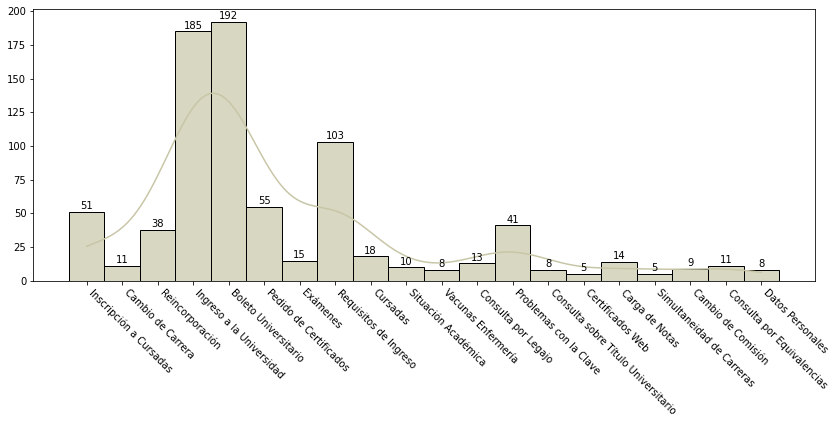

			Distribución de clases para el Test dataset


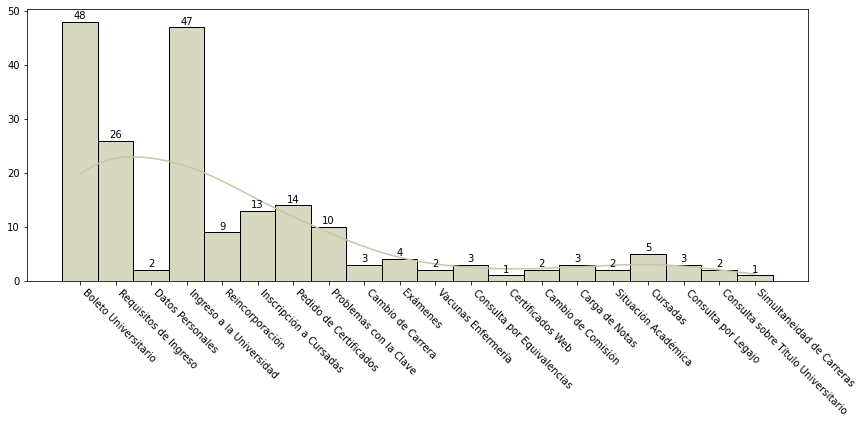

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def hist_clases(serie_clases, desc_plot, filename_plot):
  """
  Se plotean las clases en función de la distribución de la frecuencia
  observada en cada dataset
  """

  # Set figure size
  plt.figure(figsize=(14,5))

  ax = sns.histplot(serie_clases, kde=True, stat='count', 
                    bins=serie_clases.unique(), binwidth=0.06, 
                    color='#c8c6a7', alpha=0.7)

  ax.set_xticklabels(serie_clases.unique(),
                    rotation=-45, 
                    horizontalalignment='left', fontweight='light')

  for p in ax.patches:
      ax.annotate(f'{p.get_height():.0f}\n',
                  (p.get_x() + p.get_width() / 2, p.get_height()), 
                  ha='center', va='center', color='black')

  # Quito el nombre de los ejes (de forma rústica)
  plt.xlabel('', fontsize=12)
  plt.ylabel('', fontsize=12)

  # Guardo el plot en un png
  plt.savefig(filename_plot, optimize=True, transparent=True, bbox_inches = 'tight')

  # Muestro el gráfico con una descripción
  print(f'\t\t\tDistribución de clases para el {desc_plot}')
  plt.show()  

hist_clases(correos_train['clase'], 'Train dataset', 'histograma_train.png')
#hist_clases(total_etiquetados['clase'], 'Total dataset', 'histograma_total.png')
hist_clases(correos_test['clase'], 'Test dataset', 'histograma_test.png')

In [64]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

correos_train.query("clase == 'Inscripción y desarrollo de Cursadas'")[['Consulta', 'clase']]

,Consulta,clase
22,"buen día, queria saber como quedan los horarios para la asignatura teoria y tecnica impositiva i en la sede lujan, ya que el horario cuando me inscribi era los lunes de 19 a 22 hs y los jueves de 18 a 21 hs pero ayer el profesor alvarez comento que el horario de los jueves se modifico. por favor necesito confirmar los horarios. muchas gracias.",Cursadas
73,"hola, buenas noches. necesitaban saber cuando comenzaríamos el desarrollo del primer cuatrimestre, en el calendario académico dice el 6/03 pero quería averiguar por los paros que estan programados para el 6 y 7 de marzo. desde ya muchas gracias.",Cursadas
154,no me deja ingresar a las materias con mi número de documento ni tampoco contraseña.,Cursadas
155,hola quisiera saber que materias puedo cursar el segundo cuatrimestre,Cursadas
246,mi consulta es sobre la materia introduccion al trabajo social yo la curse en 2016 mi pregunta es el vencimiento de la regularidad si es de 2 o3 años si es de 2 años mi ultima posibilidad seria ahora en diciembre esa es mi consulta.muchas gracias,Cursadas
302,buenas tardes les queria consultar por la inscripcion para el taller (de febrero) previo a la cursada de las materias de la carrera (lic. comercio internacional) ya que ingreso los datos correspondientes y no me es posible ingresar. desde ya muchas gracias joel gomez,Cursadas
387,hola .. si yo tengo promocionada introduccion a la administracion porque motivo no me figura para cursar administracion general ?,Cursadas
447,"buenas tardes, quería saber qué día inicia el primer cuatrimestre.. gracias espero su respuesta",Cursadas
494,no puedo acceder a los dias y horarios de las materias,Cursadas
502,buenas tardes... mi consulta es porque cuando inhreso mi dni en el perfil de aspirantes no hay ninguna informacion. gracias.,Cursadas


# Referencias:
1. [Presentación](0) de apoyo al [Proyecto de Investigación](1) "Clasificación automática de correos electrónicos".

2. Clasificacion de textos por etiquetado de palabras: [short paper](2).

3. [API](3) del diccionario Collins.

4. [Funciones](4) de la [API](3) del diccionario Collins.

5. Librería [clusteval](5) para la evaluación KMeans.

[0]:https://docs.google.com/presentation/d/1-gdZ3dUI2pAfXM6Bgau53U7G4g2Bkv6DlxGESnu7A20/edit?usp=sharing 
[1]:https://github.com/jumafernandez/clasificacion_correos 
[2]:https://www.aaai.org/Papers/AAAI/2004/AAAI04-068.pdf
[3]:https://pypi.org/project/collins-client/
[4]:https://api.collinsdictionary.com/api/v1/documentation/html
[5]:https://clusteval.sdu.dk/1/mains